<a href="https://colab.research.google.com/github/Nivratti/Face-Anti-Spoofing/blob/master/face_anti_spoofing_face_only_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face anti spoofing on cropped faces

**CNN and transfer learning**

Dataset: NUAA cropped faces


## **Connect Google Colab with Google Drive**

---



In [0]:
from google.colab import drive

In [6]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [7]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


## prevent-google-colab-from-disconnecting

Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. This means, if user does not interact with his Google Colab notebook for more than 90 minutes, its instance is automatically terminated. Also, maximum lifetime of a Colab instance is 12 hours.

Solution:

Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with Ctrl+Shift+I then click on console tab and type this on the console prompt. (for mac press Option+Command+I)

inser below code on console

```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton, 1200000);
```




## Execution -- Auto-time plugin

In [8]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=518c41c941c083c5235052c5040db9fabd943ce6571bc6e3884763cc212ae46a
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


## utility methods

### import packages

In [9]:
from numpy import asarray
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from matplotlib import pyplot as plt
import seaborn as sns
import os, random
import shutil

time: 230 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### image utility

In [10]:
def read_image(image_path, method="PIL", rgb=True):
    """
    Read image from disk
    
    Args:
        image_path (str): Image path
        method (str, optional): which library to use. Defaults to "PIL".
        rgb (bool, optional): convert to rgb. Defaults to True.
    
    Returns:
        tuple: image_object, and image pixels in numpy format
    """
    if method == "PIL":
        # load image from file
        image = Image.open(image_path)
        if rgb:
            # convert to RGB, if needed
            image = image.convert('RGB')
        # convert to array
        # obtain_image_pixels
        pixels = asarray(image)
        return (image, pixels)
    elif method == "CV":
        print("Not implimented yet")
        return (False, False)
    elif method == "MATPLOT":
        print("Not implimented yet")
        return (False, False)
    else:
        print("Please select proper reading method")
        return (False, False)

time: 5.58 ms


In [11]:
def extract_faces_from_image(image_array, face_boxes, required_size=(160, 160), convert_2_numpy=True):
    """
    Extract face region from image array
    
    Args:
        image_array (array): Image pixels in numpy format
        face_boxes (list): list of face bounding boxes
        required_size (tuple, optional): Final image resolution. Defaults to (160, 160).
        convert_2_numpy (bool, optional): convert pil face image to numpy. Defaults to True.
    
    Returns:
        list: If convert_2_numpy flag set to true then it returns list of faces(face regions-roi) in numpy format 
              otherwise it returns faces in pillow format
    """
    face_images = []

    for face_box in face_boxes:
        # extract the bounding box from the first face
        x1, y1, width, height = face_box

        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height

        # extract the face
        extracted_face_array = image_array[y1:y2, x1:x2]

        # resize pixels to the model size
        face_image = Image.fromarray(extracted_face_array)
        face_image = face_image.resize(required_size)

        if convert_2_numpy:
            face_array = asarray(face_image)
            face_images.append(face_array)
        else:
            face_images.append(face_image)

    return face_images


time: 9.15 ms


### file/ dir utils

In [12]:
import os

def list_files(root_dir, mindepth = 1, maxdepth = float('inf'), filter_ext=[], return_relative_path=False):
    """
    Usage:

    d = get_all_files(rootdir, mindepth = 1, maxdepth = 2)

    This returns a list of all files of a directory, including all files in
    subdirectories. Full paths are returned.

    WARNING: this may create a very large list if many files exists in the 
    directory and subdirectories. Make sure you set the maxdepth appropriately.

    rootdir  = existing directory to start
    mindepth = int: the level to start, 1 is start at root dir, 2 is start 
               at the sub direcories of the root dir, and-so-on-so-forth.
    maxdepth = int: the level which to report to. Example, if you only want 
               in the files of the sub directories of the root dir, 
               set mindepth = 2 and maxdepth = 2. If you only want the files
               of the root dir itself, set mindepth = 1 and maxdepth = 1
    
    filter_ext(list, optional) :  filter files ex. [.jpg, .png]
    return_relative_path(bool): Default false. If true return relative path else return absolute path
    """
    root_dir = os.path.normcase(root_dir)
    file_paths = []
    root_depth = root_dir.rstrip(os.path.sep).count(os.path.sep) - 1
    lowered_filter_ext = tuple([ext.lower() for ext in filter_ext])

    for abs_dir, dirs, files in os.walk(root_dir):
        depth = abs_dir.count(os.path.sep) - root_depth
        if mindepth <= depth <= maxdepth:
            for filename in files:
                if filter_ext:
                    if not filename.lower().endswith(lowered_filter_ext):
                        continue

                if return_relative_path:
                    rel_dir = os.path.relpath(abs_dir, root_dir)
                    if rel_dir == ".":
                        file_paths.append(filename)
                    else:
                        file_paths.append(os.path.join(rel_dir, filename))
                else:
                    # append full absolute path
                    file_paths.append(os.path.join(abs_dir, filename))

        elif depth > maxdepth:
            # del dirs[:] 
            pass
    return file_paths

time: 17.2 ms


### face related

In [13]:
def extract_save_face(src, face_detector):
    """
    Extract face from image and save
    
    Args:
        src (str): Source image file path
        dest (str): Dest image file path
        face_detector (object): MTCNN face detector
    """
    filename, file_extension = os.path.splitext(src)

    pil_image, image_array = read_image(src)

    detected_faces = face_detector.detect_faces(image_array)

    face_boxes = [detected_face['box'] for detected_face in detected_faces]

    face_rois = extract_faces_from_image(image_array, face_boxes, convert_2_numpy=False)

    if face_rois:
        img_single_face = face_rois[0]
        # pillow write image
        img_single_face.save(src)
        # print(f"saved face from {src}")
        return True
    else:
        print(f"Skipping.. No face found in {src}")
        return False


time: 7 ms


In [14]:
# crop faces from full images --- 
def crop_face_dir_recursive(source_dir, files_list, face_detector):
    for file in files_list:
        src_file = os.path.join(source_dir, file)
        extract_save_face(src_file, face_detector)
    return True


time: 1.95 ms


#### Highlight face area

In [15]:
def highlight_faces(pil_image, face_boxes, outline_color="red"):
    """
    Highlight faces using pillow
    
    Args:
        pil_image (object): PiL image object
        face_boxes (list): list of face boxes
        outline_color (str, optional): Border color. Defaults to "red".
    
    Returns:
        [type]: [description]
    """
    draw = ImageDraw.Draw(pil_image)
    # for each face, draw a rectangle based on coordinates
    for face_box in face_boxes:
        x, y, width, height = face_box
        rect_start = (x, y)
        rect_end = ((x + width), (y + height))
        draw.rectangle((rect_start, rect_end), outline=outline_color)
    return pil_image

time: 3.15 ms


## Visualization Utilities

### Plotting accuracy and loss graph

In [144]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history, y_lim=[0, 1]):
  axes = plt.axes()
  axes.set_ylim(y_lim)

  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  axes = plt.axes()
  # axes.set_ylim([0, 1])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

time: 6.86 ms


### confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(
    y_true, yhat_classes, classes, figsize=(8,6), cmap="Blues",
    linewidths=0.02, linecolor='black'
    ):
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        conf_mat, annot=True, fmt='3.0f', cmap=cmap, 
        xticklabels=classes, yticklabels=classes,
        linewidths=linewidths, linecolor=linecolor,
    )
    plt.title('Confusion_matrix', y=1.05, size=15)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

time: 101 ms


### Accuracy, Precision score, Recall, F1-socre

In [18]:
# calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

def calculate_extra_metrices(y_true, yhat_classes):
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_true, yhat_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_true, yhat_classes, average="weighted")
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_true, yhat_classes, average="weighted")
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_true, yhat_classes, average="micro")
  print('F1 score: %f' % f1)

time: 4.91 ms


### dataset related

In [19]:
from os import listdir
from os.path import isdir
import numpy as np

def load_img_dataset(directory, target_size=(224, 224), make_grey=False):
    """
    load a dataset that contains one subdir for each class that in turn contains images
    
    Args:
        directory (str): Directory name with fullpath
        is_extract_face (bool, optional): If true extract face from image first and then save. If source image is already cropped face then no need to extract face so set to false. Defaults to True.
    
    Returns:
        Tuple: Tuple of ndarray dataset face data and labels(taken from folder name)
    """
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        subdir_path = os.path.join(directory, subdir)
  
        # skip any files that might be in the dir
        if not isdir(subdir_path):
            continue

        # load all image filenames in the subdirectory
        image_files = list_files(
            root_dir=subdir_path,
            filter_ext=['.jpg', '.jpeg', '.png'], 
            return_relative_path=False, # get absolute path
        )

        images = []
        # extract image 
        for img_file_path in image_files:
            pil_img, _ = read_image(img_file_path, method="PIL", rgb=True)
            pil_img = pil_img.resize(target_size)

            if make_grey:
                pil_img = pil_img.convert("L")
                img_array = np.array(pil_img)
                img_array = np.expand_dims(img_array, axis=-1) # add 1 channel ex.(28, 28) to (28, 28, 1)
            else:
                img_array = np.array(pil_img)
            images.append(img_array)

        # generate labels -- make it equal length of image_files
        labels = [subdir for _ in range(len(image_files))]

        # summarize progress
        print('>loaded %d examples for class: %s' % (len(image_files), subdir))

        # store
        X.extend(images)
        y.extend(labels)
    return asarray(X), asarray(y)

time: 19.3 ms


## Set Global variables

In [20]:
import os

DRIVE_BASE_DIR = '/content/gdrive/My Drive/deep_learning/face-anti-spoofing/'

DRIVE_DATASET_DIR = os.path.join(DRIVE_BASE_DIR, "face-only/dataset/")

# model checkpoints
CKPT_DIR = os.path.join(DRIVE_BASE_DIR, "ckpt/")
os.makedirs(CKPT_DIR, exist_ok=True)

time: 370 ms


## Load dataset

In [21]:
dataset_file_name = "NUAA_cropped_faces_dataset.zip"

dataset_drive_path = os.path.join(DRIVE_DATASET_DIR, dataset_file_name)

time: 971 µs


#### copy zip file from drive to local storage

In [22]:
!cp "$dataset_drive_path" "$dataset_file_name"

time: 5.48 s


In [23]:
!unzip "$dataset_file_name"

Streaming output truncated to the last 5000 lines.
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_00_01_304.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_01_03_284.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_08_03_176.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_00_01_88.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_02_03_1.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_02_03_471.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_02_03_399.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_00_01_368.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_00_01_483.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_00_01_67.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_02_03_287.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_04_03_186.jpg  
  inflating: NUAA_cropped_faces_dataset/fake/0006/0006_00_01_03_4

### Load data and labels 

In [24]:
dataset_folder = "NUAA_cropped_faces_dataset"

time: 1.16 ms


In [61]:
X, y = load_img_dataset(dataset_folder, target_size=(128, 128))

>loaded 5105 examples for class: real
>loaded 7041 examples for class: fake
time: 15.8 s


view info

In [62]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (12146, 128, 128, 3)
y shape: (12146,)
time: 1.18 ms


plot the label count

Text(0.5, 1.0, 'Labels')

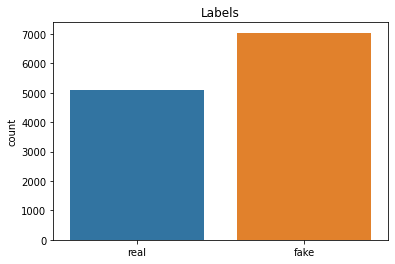

time: 118 ms


In [63]:
sns.countplot(y)
plt.title("Labels")

## Label Encoding

### Integer encoding (String to int)

In [64]:
# Keras expects an integer vector from 0 to num_classes.

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
encoded_y = labelencoder.fit_transform(y)

# Print shapes
print("Shape of encoded_labels: {}".format(encoded_y.shape))


Shape of encoded_labels: (12146,)
time: 3.82 ms


In [65]:
classes = labelencoder.classes_
print(f'classes: {classes}')

classes: ['fake' 'real']
time: 1.01 ms


In [66]:
num_classes = len(classes)
print("Total classes: {}".format(num_classes))

Total classes: 2
time: 1.08 ms


save label encoder

In [67]:
import numpy as np

le_filename = "label_encoder_classes.npy"
np.save(le_filename, labelencoder.classes_)

## loading in test
# le = LabelEncoder()
# le.classes_ = numpy.load(le_filename)

time: 2.38 ms


### Categorical encoding

Encode labels to one hot vectors


*   2 => [0,0,1,0,0,0,0,0,0,0]
*   4 => [0,0,0,0,1,0,0,0,0,0]

![Encode labels](https://drive.google.com/uc?id=1EV85hrAv439AJMmfyQX1Gwb_hcc3J2aq)


In [68]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
encoded_y = to_categorical(encoded_y, num_classes = num_classes)

time: 1.5 ms


## Train Test Split
We split the data into train and test sets.

*   train size is 80%.
*   test size is 20%.

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size = 0.20, random_state = 0)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (9716, 128, 128, 3)
X_test shape: (2430, 128, 128, 3)
y_train shape: (9716, 2)
y_test shape: (2430, 2)
time: 183 ms


single sample records

In [70]:
print(X_train[0][0][0:5])

[[245 251 253]
 [245 252 253]
 [247 254 253]
 [238 249 241]
 [132 146 136]]
time: 1.19 ms


In [71]:
print(y_train[0:5])

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
time: 1.18 ms


### Normalising the data

You want to make sure that your data is in the same scale / form to increase the integrity of the data. We call this normalising the data. We want the data to be on a scale from 0 to 1.

If we would not Normalise our data, larger data points in the data can cause instability in our Neural Network.

In [72]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalization
X_train /= 255
X_test /= 255

time: 837 ms


view data after normalization

In [73]:
print(X_train[0][0][0:5])

[[0.9607843  0.9843137  0.99215686]
 [0.9607843  0.9882353  0.99215686]
 [0.96862745 0.99607843 0.99215686]
 [0.93333334 0.9764706  0.94509804]
 [0.5176471  0.57254905 0.53333336]]
time: 1.67 ms


## Deep learning models

### load packages

In [74]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding, CuDNNLSTM, CuDNNGRU
from keras.optimizers import Adam
from keras.layers import SpatialDropout2D,Dropout,Bidirectional,Conv2D,GlobalMaxPooling2D,MaxPooling2D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization

time: 6.29 ms


### Convolutional Neural Net Model

#### define architecture

In [75]:
# input_shape = (160, 160, 3)
input_shape = X_train[0].shape

def build_cnn_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                    activation ='relu', input_shape = input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))

    optimizer = Adam(lr = 0.0001)
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
    return model

cnn_model = build_cnn_model()

time: 91.5 ms


In [76]:
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)            

#### Avoid wasting resources with EarlyStopping and ModelCheckpoint

In [77]:
# Adding the callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint_path = "cnn_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 2.86 ms


#### start model training

In [78]:
epochs = 250
batch_size = 64 # 128 # use more if gpu available - for faster processing 

history = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=cb_list,
)

Train on 9716 samples, validate on 2430 samples
Epoch 1/250
9716/9716 [==============================] - 5s 561us/step - loss: 0.2970 - accuracy: 0.8729 - val_loss: 0.1593 - val_accuracy: 0.9609

Epoch 00001: val_loss improved from inf to 0.15934, saving model to cnn_model.best.hdf5
Epoch 2/250
9716/9716 [==============================] - 5s 508us/step - loss: 0.0795 - accuracy: 0.9739 - val_loss: 0.0607 - val_accuracy: 0.9860

Epoch 00002: val_loss improved from 0.15934 to 0.06069, saving model to cnn_model.best.hdf5
Epoch 3/250
9716/9716 [==============================] - 5s 507us/step - loss: 0.0522 - accuracy: 0.9843 - val_loss: 0.0517 - val_accuracy: 0.9831

Epoch 00003: val_loss improved from 0.06069 to 0.05174, saving model to cnn_model.best.hdf5
Epoch 4/250
9716/9716 [==============================] - 5s 500us/step - loss: 0.0272 - accuracy: 0.9929 - val_loss: 0.0291 - val_accuracy: 0.9926

Epoch 00004: val_loss improved from 0.05174 to 0.02911, saving model to cnn_model.best.h

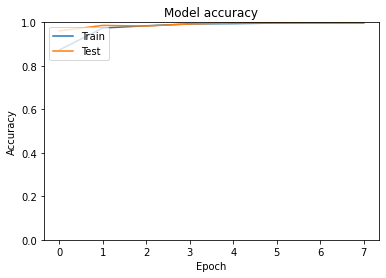

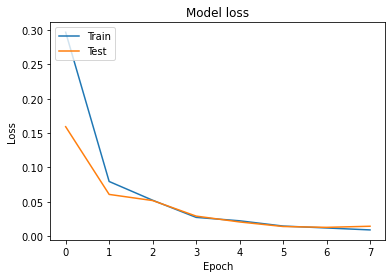

time: 249 ms


In [79]:
plot_accuracy_loss(history)

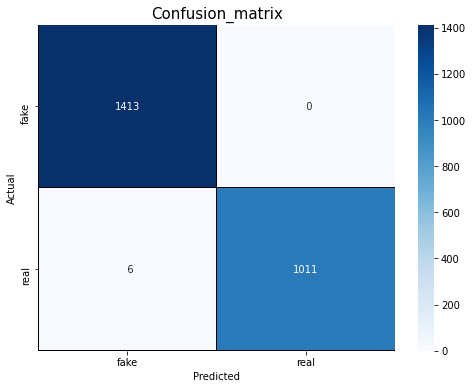

time: 733 ms


In [80]:
y_pred = cnn_model.predict_classes(X_test)

# convert one hot encoded labels to single-digit ones
rounded_test_labels = np.argmax(y_test, axis=1)

plot_confusion_matrix(rounded_test_labels, y_pred, classes)

In [81]:
calculate_extra_metrices(
    y_true=rounded_test_labels, 
    yhat_classes=y_pred
)

Accuracy: 0.997531
Precision: 0.997541
Recall: 0.997531
F1 score: 0.997531
time: 7.14 ms


## Transfer learning

### VGG 16

In [184]:


# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16, ResNet50

def build_vgg16_model(input_shape, num_classes):
    # loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
    vgg = VGG16(input_shape = input_shape, weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

    # this will exclude the initial layers from training phase as there are already been trained.
    for layer in vgg.layers:
        layer.trainable = False

    x = Flatten()(vgg.output)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(num_classes, activation = 'softmax')(x)

    model = Model(inputs = vgg.input, outputs = x)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = X_train[0].shape
vgg16_model = build_vgg16_model(input_shape, num_classes)

time: 270 ms


In [185]:
vgg16_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

#### Avoid wasting resources with EarlyStopping and ModelCheckpoint

In [186]:
# Adding the callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint_path = "vgg16_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 2.81 ms


#### start model training

In [187]:
epochs = 250
batch_size = 64 # 64 # use more if gpu available - for faster processing 

history = vgg16_model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=cb_list,
)

Train on 9716 samples, validate on 2430 samples
Epoch 1/250
9716/9716 [==============================] - 10s 1ms/step - loss: 0.0705 - accuracy: 0.9755 - val_loss: 0.0040 - val_accuracy: 0.9996

Epoch 00001: val_loss improved from inf to 0.00397, saving model to vgg16_model.best.hdf5
Epoch 2/250
9716/9716 [==============================] - 10s 1ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.0015 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00397 to 0.00148, saving model to vgg16_model.best.hdf5
Epoch 3/250
9716/9716 [==============================] - 10s 1ms/step - loss: 8.4295e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00148 to 0.00115, saving model to vgg16_model.best.hdf5
Epoch 4/250
9716/9716 [==============================] - 10s 1ms/step - loss: 3.8140e-04 - accuracy: 1.0000 - val_loss: 5.0254e-04 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00115 to 0.00050, saving model to vg

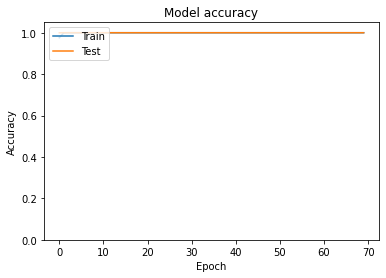

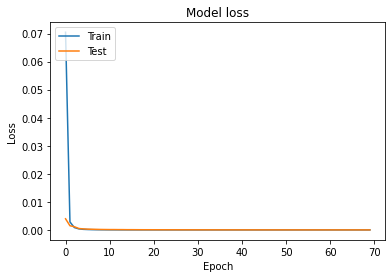

time: 257 ms


In [188]:
plot_accuracy_loss(history, y_lim=[0, 1.05])

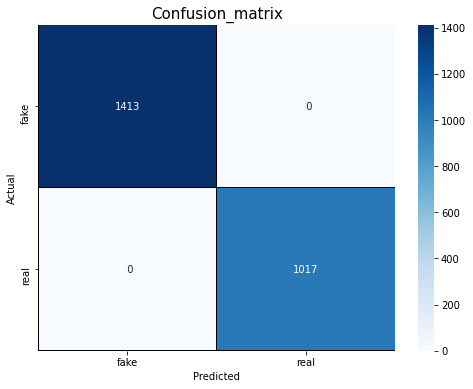

time: 2.29 s


In [189]:
# we are using functional api -- so predict_classes not available
# need to convert to 1d
y_pred = vgg16_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# convert one hot encoded labels to single-digit ones
rounded_test_labels = np.argmax(y_test, axis=1)

plot_confusion_matrix(rounded_test_labels, y_hat, classes)

In [190]:
calculate_extra_metrices(
    y_true=rounded_test_labels, 
    yhat_classes=y_pred
)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
time: 7.57 ms


### VGG 19

In [191]:
# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG19

def build_vgg19_model(input_shape, num_classes):
    # loading the weights of VGG19 without the top layer. These weights are trained on Imagenet dataset.
    vgg = VGG19(input_shape = input_shape, weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

    # this will exclude the initial layers from training phase as there are already been trained.
    for layer in vgg.layers:
        layer.trainable = False

    x = Flatten()(vgg.output)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(num_classes, activation = 'softmax')(x)

    model = Model(inputs = vgg.input, outputs = x)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = X_train[0].shape
vgg19_model = build_vgg16_model(input_shape, num_classes)

time: 270 ms


In [192]:
vgg19_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

#### Avoid wasting resources with EarlyStopping and ModelCheckpoint

In [193]:
# Adding the callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint_path = "vgg19_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 3.06 ms


#### start model training

In [194]:
epochs = 250
batch_size = 64 # 64 # use more if gpu available - for faster processing 

history = vgg19_model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=cb_list,
)

Train on 9716 samples, validate on 2430 samples
Epoch 1/250
9716/9716 [==============================] - 10s 1ms/step - loss: 0.0923 - accuracy: 0.9702 - val_loss: 0.0056 - val_accuracy: 0.9996

Epoch 00001: val_loss improved from inf to 0.00558, saving model to vgg19_model.best.hdf5
Epoch 2/250
9716/9716 [==============================] - 10s 1ms/step - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0023 - val_accuracy: 0.9996

Epoch 00002: val_loss improved from 0.00558 to 0.00228, saving model to vgg19_model.best.hdf5
Epoch 3/250
9716/9716 [==============================] - 10s 1ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.0013 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00228 to 0.00135, saving model to vgg19_model.best.hdf5
Epoch 4/250
9716/9716 [==============================] - 10s 1ms/step - loss: 6.3585e-04 - accuracy: 1.0000 - val_loss: 7.9686e-04 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00135 to 0.00080, saving model to vgg19_

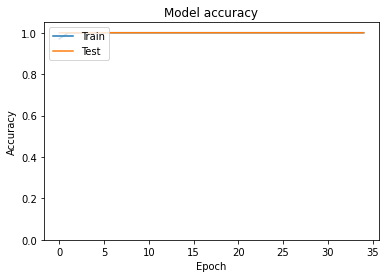

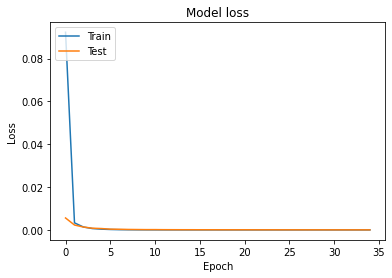

time: 251 ms


In [195]:
plot_accuracy_loss(history, y_lim=[0, 1.05])

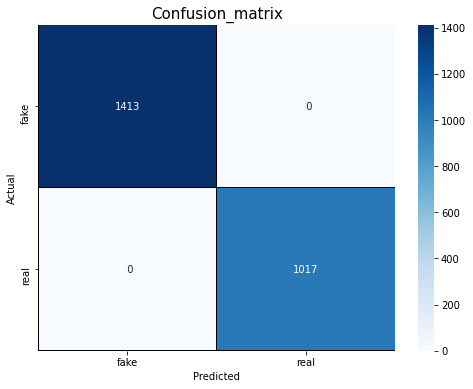

time: 2.28 s


In [196]:
# we are using functional api -- so predict_classes not available
# need to convert to 1d
y_pred = vgg19_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# convert one hot encoded labels to single-digit ones
rounded_test_labels = np.argmax(y_test, axis=1)

plot_confusion_matrix(rounded_test_labels, y_hat, classes)

In [197]:
calculate_extra_metrices(
    y_true=rounded_test_labels, 
    yhat_classes=y_pred
)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
time: 8.37 ms


### Resnet-50

In [200]:
# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import ResNet50

def build_resnet50_model(input_shape, num_classes):
    # loading the weights of RESNET50 without the top layer. These weights are trained on Imagenet dataset.
    resnet = ResNet50(input_shape = input_shape, weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

    # this will exclude the initial layers from training phase as there are already been trained.
    for layer in resnet.layers:
        layer.trainable = False

    x = Flatten()(resnet.output)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(num_classes, activation = 'softmax')(x)

    model = Model(inputs = resnet.input, outputs = x)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = X_train[0].shape
resnet50_model = build_resnet50_model(input_shape, num_classes)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


time: 2.7 s


In [201]:
resnet50_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_32[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

#### Avoid wasting resources with EarlyStopping and ModelCheckpoint

In [202]:
# Adding the callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint_path = "resnet50_model_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 2.44 ms


#### start model training

In [203]:
epochs = 250
batch_size = 64 # 64 # use more if gpu available - for faster processing 

history = resnet50_model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=cb_list,
)

Train on 9716 samples, validate on 2430 samples
Epoch 1/250
9716/9716 [==============================] - 16s 2ms/step - loss: 0.0787 - accuracy: 0.9873 - val_loss: 2.0008 - val_accuracy: 0.5815

Epoch 00001: val_loss improved from inf to 2.00083, saving model to resnet50_model_model.best.hdf5
Epoch 2/250
9716/9716 [==============================] - 13s 1ms/step - loss: 9.2112e-04 - accuracy: 0.9999 - val_loss: 1.7891 - val_accuracy: 0.5815

Epoch 00002: val_loss improved from 2.00083 to 1.78912, saving model to resnet50_model_model.best.hdf5
Epoch 3/250
9716/9716 [==============================] - 13s 1ms/step - loss: 1.6469e-05 - accuracy: 1.0000 - val_loss: 1.7907 - val_accuracy: 0.5815

Epoch 00003: val_loss did not improve from 1.78912
Epoch 4/250
9716/9716 [==============================] - 13s 1ms/step - loss: 1.2605e-05 - accuracy: 1.0000 - val_loss: 1.8522 - val_accuracy: 0.5815

Epoch 00004: val_loss did not improve from 1.78912
Epoch 00004: early stopping
time: 57.6 s


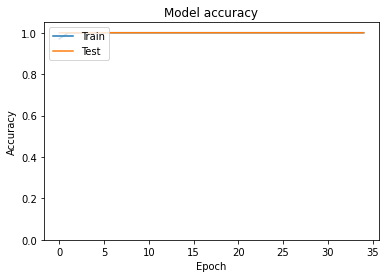

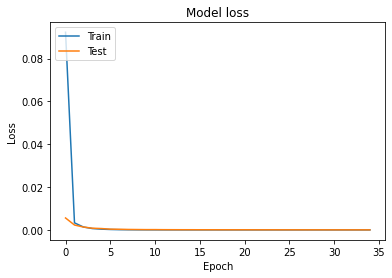

time: 251 ms


In [0]:
plot_accuracy_loss(history, y_lim=[0, 1.05])

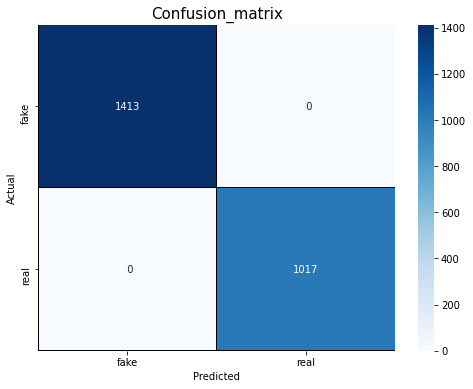

time: 2.28 s


In [0]:
# we are using functional api -- so predict_classes not available
# need to convert to 1d
y_pred = vgg19_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# convert one hot encoded labels to single-digit ones
rounded_test_labels = np.argmax(y_test, axis=1)

plot_confusion_matrix(rounded_test_labels, y_hat, classes)

In [0]:
calculate_extra_metrices(
    y_true=rounded_test_labels, 
    yhat_classes=y_pred
)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
time: 8.37 ms


### MobileNet

In [204]:
# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import MobileNet

def build_mobilenet_model(input_shape, num_classes):
    # loading the weights of MobileNet without the top layer. These weights are trained on Imagenet dataset.
    mobilenet = MobileNet(input_shape = input_shape, weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

    # this will exclude the initial layers from training phase as there are already been trained.
    for layer in mobilenet.layers:
        layer.trainable = False

    x = Flatten()(mobilenet.output)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(num_classes, activation = 'softmax')(x)

    model = Model(inputs = mobilenet.input, outputs = x)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = X_train[0].shape
mobilenet_model = build_mobilenet_model(input_shape, num_classes)

17227776/17225924 [==============================] - 2s 0us/step
time: 4.98 s


In [205]:
mobilenet_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128

#### Avoid wasting resources with EarlyStopping and ModelCheckpoint

In [207]:
# Adding the callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint_path = "mobilenet_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 3.19 ms


#### start model training

In [208]:
epochs = 250
batch_size = 64 # 64 # use more if gpu available - for faster processing 

history = mobilenet_model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=cb_list,
)

Train on 9716 samples, validate on 2430 samples
Epoch 1/250
9716/9716 [==============================] - 7s 764us/step - loss: 0.0679 - accuracy: 0.9889 - val_loss: 3.5394 - val_accuracy: 0.7095

Epoch 00001: val_loss improved from inf to 3.53945, saving model to mobilenet_model.best.hdf5
Epoch 2/250
9716/9716 [==============================] - 6s 612us/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.5151 - val_accuracy: 0.9140

Epoch 00002: val_loss improved from 3.53945 to 0.51509, saving model to mobilenet_model.best.hdf5
Epoch 3/250
9716/9716 [==============================] - 6s 616us/step - loss: 0.0168 - accuracy: 0.9984 - val_loss: 1.8745 - val_accuracy: 0.8436

Epoch 00003: val_loss did not improve from 0.51509
Epoch 4/250
9716/9716 [==============================] - 6s 615us/step - loss: 0.0247 - accuracy: 0.9984 - val_loss: 5.5999 - val_accuracy: 0.6683

Epoch 00004: val_loss did not improve from 0.51509
Epoch 00004: early stopping
time: 26.7 s


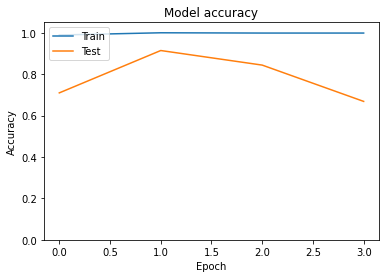

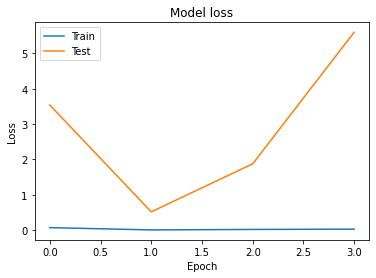

time: 252 ms


In [209]:
plot_accuracy_loss(history, y_lim=[0, 1.05])

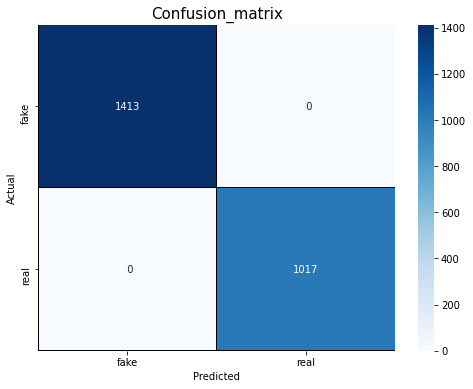

time: 2.28 s


In [0]:
# we are using functional api -- so predict_classes not available
# need to convert to 1d
y_pred = vgg19_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# convert one hot encoded labels to single-digit ones
rounded_test_labels = np.argmax(y_test, axis=1)

plot_confusion_matrix(rounded_test_labels, y_hat, classes)

In [210]:
calculate_extra_metrices(
    y_true=rounded_test_labels, 
    yhat_classes=y_pred
)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
time: 7.9 ms
